In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

### Load Model

Loading contents from file...


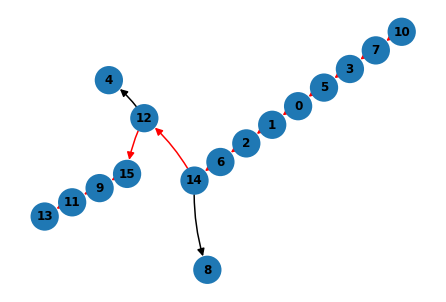

In [28]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model_legacy.pt"):
    model.load_state_dict(torch.load("model_legacy.pt"))

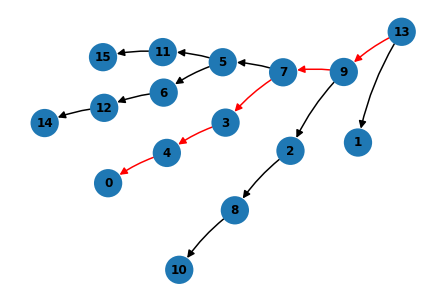

In [5]:
pred = generate_example(16, 0, order="backward", path_length=5)
if is_model_correct(model, dataset, pred):
    parse_example(pred)
cache = get_example_cache(pred, model, dataset)

In [6]:
cache[1]

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.hook_mlp_in', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out

### Attention Head Visualization

In [7]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=True)

In [8]:
cache

(['12',
  '>14',
  ',',
  '11',
  '>15',
  ',',
  '6',
  '>12',
  ',',
  '4',
  '>0',
  ',',
  '5',
  '>11',
  ',',
  '5',
  '>6',
  ',',
  '3',
  '>4',
  ',',
  '8',
  '>10',
  ',',
  '7',
  '>5',
  ',',
  '7',
  '>3',
  ',',
  '2',
  '>8',
  ',',
  '9',
  '>7',
  ',',
  '9',
  '>2',
  ',',
  '13',
  '>9',
  ',',
  '13',
  '>1',
  '|',
  '0',
  ':',
  '13',
  '>9',
  '>7',
  '>3',
  '>4',
  '>0',
  ',',
  ',',
  ',',
  ',',
  ',',
  ',',
  ',',
  ',',
  ',',
  ',',
  ',',
  ','],
 ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_ou

### Probing Dataset

In [9]:
act_names = ["blocks.3.ln2.hook_normalized", "blocks.3.mlp.hook_post", "blocks.3.attn.hook_z",
             "blocks.4.ln2.hook_normalized", "blocks.4.mlp.hook_post", "blocks.4.attn.hook_z",
             "blocks.5.ln2.hook_normalized", "blocks.5.mlp.hook_post", "blocks.5.attn.hook_z",]
model.reset_hooks()

if not os.path.exists("activations.pt"):
    print("Generating activations...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=32_000,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , "activations.pt")
else:
    acts, graphs, test_acts, test_graphs = torch.load("activations.pt")


In [10]:
def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # get adjacency matrix of only path
        # Iterate over all layers residual streams
        for key in X.keys():
            if len(acts[key][gidx].shape) == 3:
                streams = acts[key][gidx][0, start_idx-1:start_idx]
            elif len(acts[key][gidx].shape) == 4:
                streams = acts[key][gidx][0, start_idx-1:start_idx, 0]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    return X


dataX = return_probing_dataset(acts, graphs)
dataXTest = return_probing_dataset(test_acts, test_graphs)

print(dataX["blocks.5.ln2.hook_normalized"].shape)

(31442, 128)


In [11]:
del acts, test_acts
torch.cuda.empty_cache()

### Load all sparse coders

In [12]:
sparse_coders = {}

for key in dataX.keys():
    print(key)
    X = dataX[key]
    coder = SparseCoder(X.shape[1]*4, max_iter=2_500, batch_size=2048, l1_coef=0.0004, learning_rate_init=1e-4, verbose=True)
    if os.path.exists(f"sparse_coders/{key}.pt"):
        coder.load(f"sparse_coders/{key}.pt")
    else:
        coder.fit(X)
        coder.save(f"sparse_coders/{key}.pt")
    sparse_coders[key] = coder
        

blocks.3.ln2.hook_normalized
blocks.3.mlp.hook_post
blocks.3.attn.hook_z
blocks.4.ln2.hook_normalized
blocks.4.mlp.hook_post
blocks.4.attn.hook_z
blocks.5.ln2.hook_normalized
blocks.5.mlp.hook_post
blocks.5.attn.hook_z


In [13]:


def sae_hook(
    acts,
    hook,
    sae,
    key,
    dictionary
):
    # Input is size [_, P, ..., D] 
    f, r = sae.model(acts)
    dictionary[key] = f[:, 47, :].flatten()
    acts[:, 47, :] = r[:, 47, :]
    return acts

def add_sae_hooks(model, feature_dict):
    # Check all sparse coders
    sparse_coders.keys()

    for key in sparse_coders.keys():
        layer = int(key.split(".")[1])
        if "ln2" in key:
            temp_hook_fn = partial(sae_hook, sae=sparse_coders[key], dictionary=feature_dict, key=key)
            model.blocks[layer].ln2.hook_normalized.add_hook(temp_hook_fn)
            print(f"Added hook at {layer}.ln2")
        if "mlp" in key:
            temp_hook_fn = partial(sae_hook, sae=sparse_coders[key], dictionary=feature_dict, key=key)
            model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)
            print(f"Added hook at {layer}.mlp.hook_post")
        if "hook_z" in key:
            temp_hook_fn = partial(sae_hook, sae=sparse_coders[key], dictionary=feature_dict, key=key)
            model.blocks[layer].attn.hook_z.add_hook(temp_hook_fn)
            print(f"Added hook at {layer}.attn.hook_z")

codes = {}
add_sae_hooks(model, codes)

Added hook at 3.ln2
Added hook at 3.mlp.hook_post
Added hook at 3.attn.hook_z
Added hook at 4.ln2
Added hook at 4.mlp.hook_post
Added hook at 4.attn.hook_z
Added hook at 5.ln2
Added hook at 5.mlp.hook_post
Added hook at 5.attn.hook_z


In [14]:

start_seed = 250_000
num_samples = 1_000

for order in ["random", "backward", "forward"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      correct = is_model_correct(model, dataset, graph)
      if correct:
        total_correct += 1

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

model.reset_hooks()

random: 99.7000%
backward: 99.0000%
forward: 100.0000%


### Experiment: Attention Blockout

Added hook at 3.ln2
Added hook at 3.mlp.hook_post
Added hook at 3.attn.hook_z
Added hook at 4.ln2
Added hook at 4.mlp.hook_post
Added hook at 4.attn.hook_z
Added hook at 5.ln2
Added hook at 5.mlp.hook_post
Added hook at 5.attn.hook_z
7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1,14>15,13>14,12>13,11>12,10>11,9>10,0>9|8:0>1>2>3>4>5>6>7>8


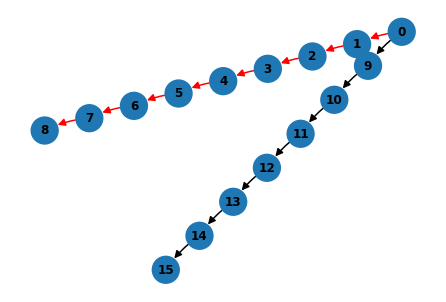

In [65]:
example = "7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1,14>15,13>14,12>13,11>12,10>11,9>10,0>9|8:0>1>2>3>4>5>6>7>8"
parse_example(example)

clean_codes = {}
pred, is_correct = eval_model(model, dataset, example, add_hooks_fn=partial(add_sae_hooks, feature_dict=clean_codes))
print(pred)

In [16]:
clean_codes

{'blocks.3.attn.hook_z': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.6315, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4873, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0198, 0.0000, 0.0000, 0.0000, 0.0000, 0.0730, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0970, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0284, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0727, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    

In [67]:
tokens = [dataset.idx2tokens[i] for i in dataset.tokenize(example)]
edges = []

for i, t in enumerate(tokens):
    if i >= 47:
        break
    if t.startswith(">"):
        edges.append((i, tokens[i-1]+tokens[i]))


In [68]:
blocking_edge = "3>4"

print("Blocking", blocking_edge)

model.reset_hooks()
corrupted_codes = {}

def corrupted_hook(model):
    attending = edges[ [e[1] for e in edges].index(blocking_edge) ][0]
    add_sae_hooks(model, corrupted_codes)
    add_attention_blockout(model, 4, 0, 47, attending)
    add_attention_blockout(model, 5, 0, 47, attending)

pred, is_correct = eval_model(model, dataset, example, add_hooks_fn=corrupted_hook)
print(pred)
print(is_correct)

Blocking 3>4
Added hook at 3.ln2
Added hook at 3.mlp.hook_post
Added hook at 3.attn.hook_z
Added hook at 4.ln2
Added hook at 4.mlp.hook_post
Added hook at 4.attn.hook_z
Added hook at 5.ln2
Added hook at 5.mlp.hook_post
Added hook at 5.attn.hook_z
7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1,14>15,13>14,12>13,11>12,10>11,9>10,0>9|8:0>4>5>6>7>8
False


In [69]:
torch.sum(corrupted_codes["blocks.4.attn.hook_z"] > 0.001)

tensor(38, device='cuda:0')

In [70]:
torch.sum(clean_codes["blocks.4.attn.hook_z"] > 0.001)

tensor(38, device='cuda:0')

In [74]:
# Features in clean that are not in corruputed
torch.where( (clean_codes["blocks.4.attn.hook_z"] - corrupted_codes["blocks.4.attn.hook_z"]).relu() > 0.05)

(tensor([209, 244, 475], device='cuda:0'),)

In [85]:
print(clean_codes["blocks.4.attn.hook_z"][244])

tensor(0.1737, device='cuda:0')


In [86]:
print(corrupted_codes["blocks.4.attn.hook_z"][244])

tensor(0.1154, device='cuda:0')


In [73]:
# Features in corrupted that are not in clean
torch.where( (corrupted_codes["blocks.4.attn.hook_z"] - clean_codes["blocks.4.attn.hook_z"]).relu() > 0.05)

(tensor([124, 285, 486], device='cuda:0'),)

In [31]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange


# max_seq_length = dataset.max_seq_length - 1


print("Getting dictionary activations")
dictionary_activations = get_dictionary_activations_at_pos(
    model,
    dataset,
    'blocks.4.attn.hook_z',
    sparse_coders["blocks.4.attn.hook_z"],
    batch_size=64
)

Getting dictionary activations


  0%|          | 0/9375 [00:00<?, ?it/s]

In [42]:
def get_feature_datapoints(found_indices, best_feature_activations, max_seq_length, dataset):
    num_datapoints = len(dataset)
    datapoint_indices = [np.unravel_index(i, (num_datapoints, max_seq_length)) for i in found_indices]
    all_activations = best_feature_activations.reshape(num_datapoints, max_seq_length).tolist()
    full_activations = []
    partial_activations = []
    text_list = []
    full_text = []
    token_list = []
    local_activations = []
    full_token_list = []
    for i, (md, s_ind) in enumerate(datapoint_indices):
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md][0])
        full_text.append(dataset.untokenize(full_tok))
        tok = dataset[md][0][:s_ind+1]
        full_activations.append(all_activations[md])
        partial_activations.append(all_activations[md][:s_ind+1])
        local_activations.append(all_activations[md][s_ind])
        text = dataset.untokenize(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, partial_activations, full_activations, local_activations

9>15,9>11,1>9,1>5,10>6,10>1,14>10,14>3,4>14,2>8,12>13,0>4,0>2,7>12,7>0|6:7>0>4>14>10>6


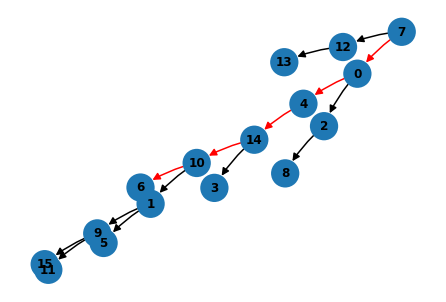

6>12,2>11,2>6,0>9,0>2,8>1,8>0,14>8,10>15,4>14,4>10,5>4,5>3,7>13,7>5|1:7>5>4>14>8>1


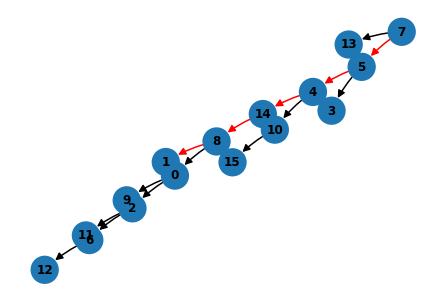

2>15,5>10,5>8,1>11,1>2,13>14,0>5,0>1,9>13,4>12,4>0,6>9,6>4,7>6,7>3|11:7>6>4>0>1>11


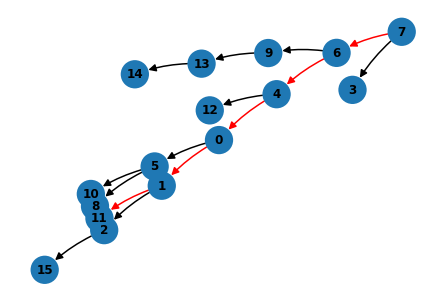

7>9,7>3,0>7,15>2,15>0,1>5,4>15,4>1,12>4,13>12,8>13,14>8,10>11,6>14,6>10|9:6>14>8>13>12>4>15>0>7>9


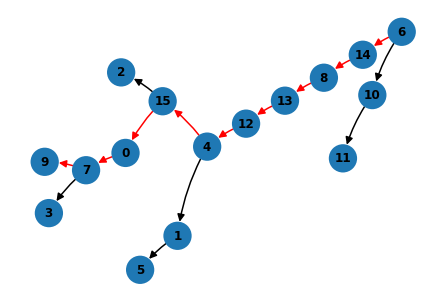

5>8,6>14,6>13,10>9,10>5,1>12,1>6,0>10,0>1,4>2,4>0,11>4,3>15,7>11,7>3|9:7>11>4>0>10>9


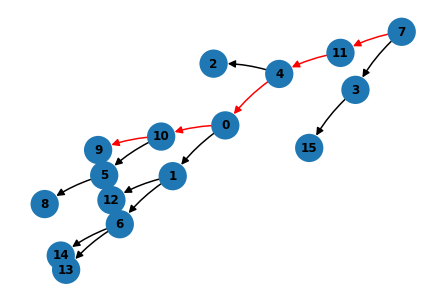

5>7,8>12,8>10,3>5,6>2,6>0,1>8,1>3,11>15,14>6,14>1,9>13,9>11,4>14,4>9|0:4>14>6>0


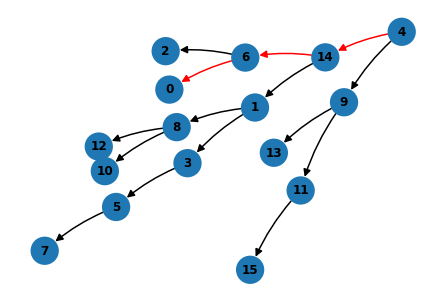

1>11,10>9,10>1,6>14,6>13,5>10,5>6,4>5,0>7,2>4,2>0,15>2,8>15,8>3,12>8|9:12>8>15>2>4>5>10>9


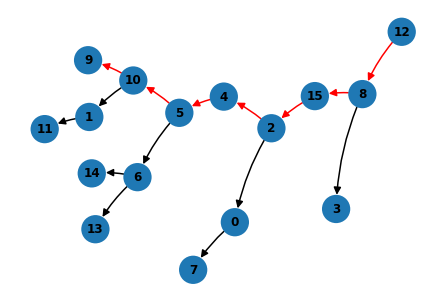

7>11,10>15,10>7,12>10,12>3,1>13,1>9,4>12,4>1,0>4,5>0,8>5,8>2,14>8,14>6|15:14>8>5>0>4>12>10>15


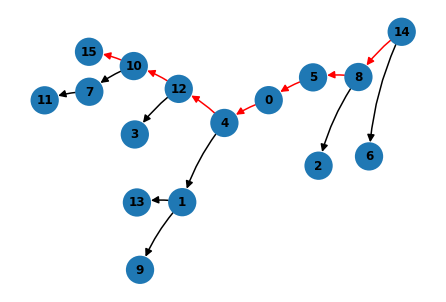

12>15,10>12,0>10,8>11,7>1,7>0,6>8,13>7,2>6,9>13,9>2,3>14,3>5,4>9,4>3|1:4>9>13>7>1


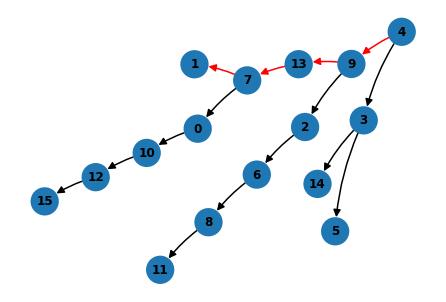

3>12,0>14,0>3,9>1,9>0,4>15,4>9,8>10,6>7,11>4,5>8,5>6,2>11,13>5,13>2|14:13>2>11>4>9>0>14


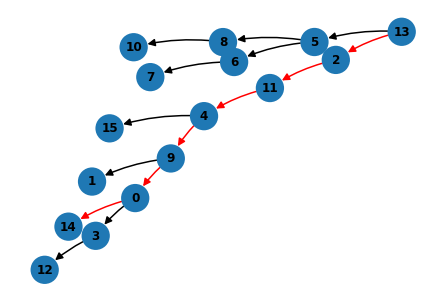

9>15,9>13,10>12,2>9,2>5,8>10,8>3,0>2,14>8,14>0,4>14,6>4,1>11,7>6,7>1|3:7>6>4>14>8>3


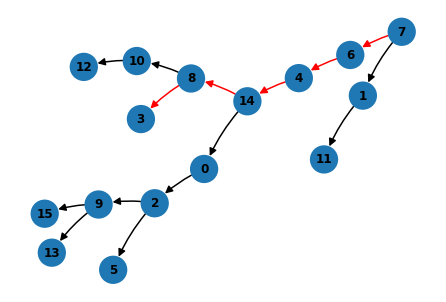

0>11,3>5,3>0,7>14,8>12,8>3,2>10,2>7,4>8,4>2,13>4,13>1,15>13,9>15,9>6|5:9>15>13>4>8>3>5


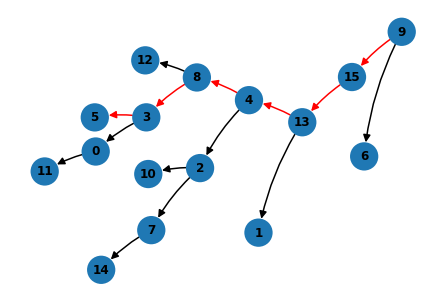

0>14,9>1,9>0,2>5,8>9,8>2,4>8,4>3,10>15,10>11,12>4,6>10,13>12,13>6,7>13|1:7>13>12>4>8>9>1


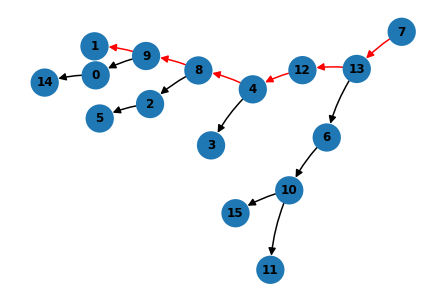

3>11,8>15,8>3,7>8,4>7,2>4,0>6,0>1,5>2,5>0,10>5,13>12,13>10,14>13,14>9|15:14>13>10>5>2>4>7>8>15


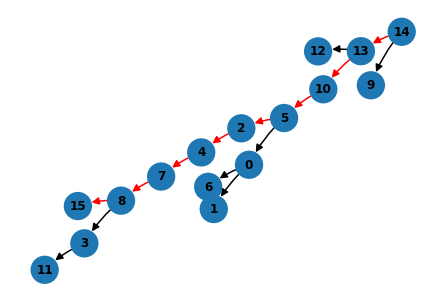

7>12,13>14,1>10,1>7,9>13,0>8,0>1,3>9,3>5,6>11,6>0,2>3,15>6,15>2,4>15|11:4>15>6>11


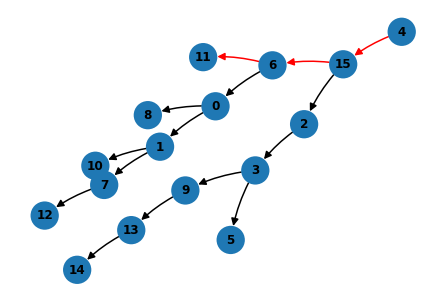

9>13,2>9,2>7,3>5,3>2,15>3,15>0,11>12,4>15,10>14,10>11,6>4,1>10,8>6,8>1|5:8>6>4>15>3>5


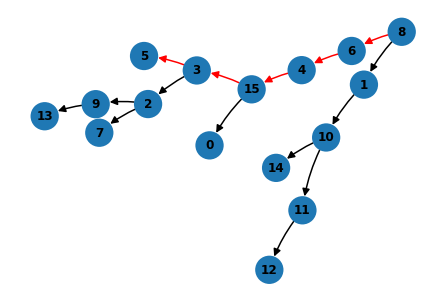

10>15,7>11,7>10,3>1,13>7,13>3,2>9,0>13,0>2,4>12,4>0,6>14,6>4,8>6,8>5|1:8>6>4>0>13>3>1


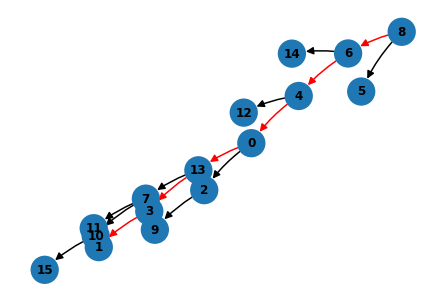

10>6,10>2,8>13,8>12,5>9,11>10,11>8,3>5,4>11,4>3,0>7,0>4,15>0,1>15,14>1|6:14>1>15>0>4>11>10>6


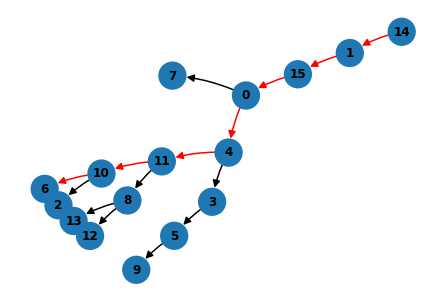

3>10,3>5,8>11,0>12,0>3,9>8,9>0,13>15,13>9,6>7,4>13,4>6,2>4,1>2,14>1|12:14>1>2>4>13>9>0>12


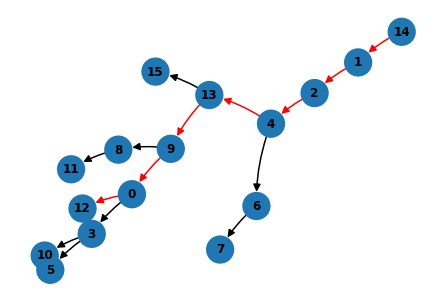

3>9,3>6,0>14,0>11,2>3,13>10,13>0,1>2,7>15,4>13,4>1,5>7,5>4,12>8,12>5|14:12>5>4>13>0>14


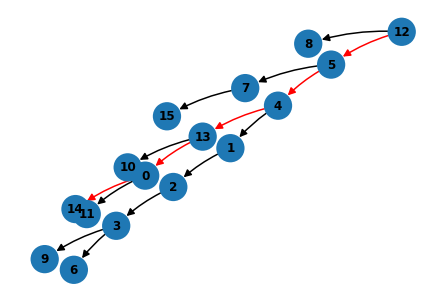

In [108]:
from feature_utils import get_feature_indices, get_feature_datapoints, save_plots_as_images, concat_images_vertically

feature = 244
num_feature_datapoints = 5000
uniform_indices = get_feature_indices(
    feature,
    dictionary_activations,
    k=num_feature_datapoints,
    setting="uniform"
).tolist()

for graph_idx in uniform_indices[:20]:
    example_str = generate_example(16, graph_idx, order='backward')
    print(example_str)
    parse_example(example_str)
    plt.show()


11>13,9>11,15>9,12>15,12>4,14>12,14>8,6>14,2>6,1>2,0>1,5>0,3>5,7>3,10>7|13:10>7>3>5>0>1>2>6>14>12>15>9>11>13


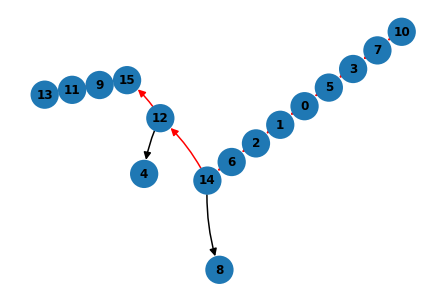

4>10,4>5,14>4,14>1,13>14,3>7,2>13,2>9,6>11,0>3,0>2,15>6,15>0,12>15,8>12|5:8>12>15>0>2>13>14>4>5


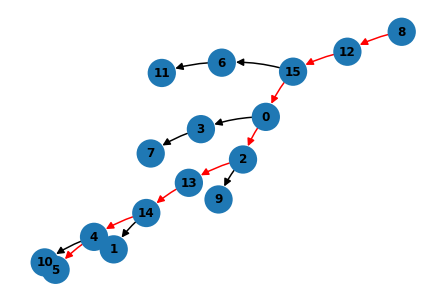

2>10,15>2,12>15,14>12,11>14,11>5,9>11,0>9,7>0,13>7,8>13,6>8,1>6,4>3,4>1|10:4>1>6>8>13>7>0>9>11>14>12>15>2>10


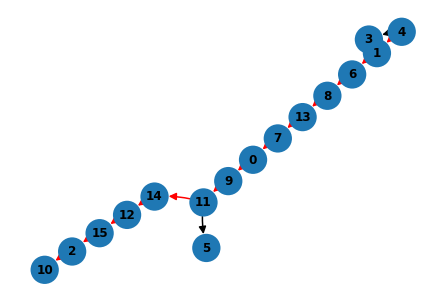

7>6,12>7,10>12,8>15,8>10,2>8,0>2,9>0,14>9,13>14,4>13,5>11,5>4,3>5,1>3|6:1>3>5>4>13>14>9>0>2>8>10>12>7>6


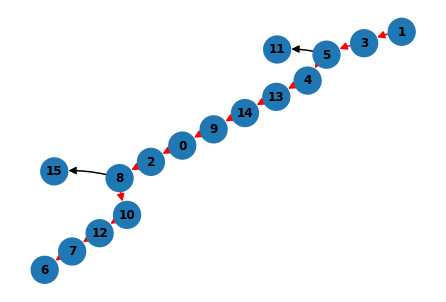

4>10,4>9,2>4,6>2,6>1,5>6,0>5,0>3,11>0,12>11,14>12,7>14,13>8,13>7,15>13|9:15>13>7>14>12>11>0>5>6>2>4>9


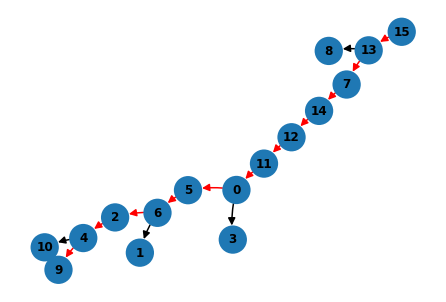

6>10,4>6,1>4,15>1,3>15,9>3,8>9,8>2,7>8,13>14,13>7,0>13,0>5,12>11,12>0|10:12>0>13>7>8>9>3>15>1>4>6>10


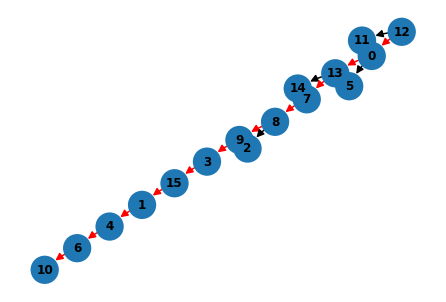

3>9,3>0,11>3,11>2,6>12,5>13,5>11,15>6,15>5,10>14,4>15,1>10,7>4,7>1,8>7|9:8>7>4>15>5>11>3>9


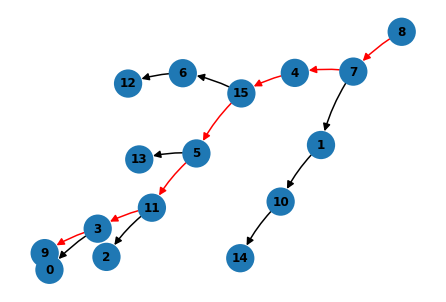

8>5,6>8,1>6,9>1,15>9,3>15,4>3,0>4,2>0,13>2,12>13,7>12,14>7,11>14,10>11|5:10>11>14>7>12>13>2>0>4>3>15>9>1>6>8>5


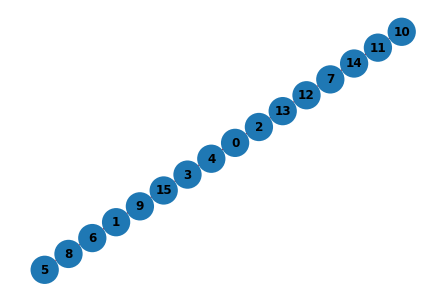

7>8,0>7,13>0,9>13,12>10,12>9,11>12,11>4,6>11,6>1,2>6,15>2,3>15,5>14,5>3|8:5>3>15>2>6>11>12>9>13>0>7>8


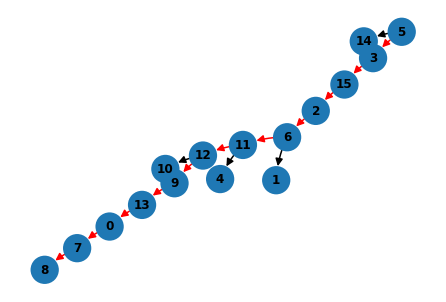

8>12,3>6,3>5,2>8,2>3,11>7,0>2,10>11,10>0,9>10,1>9,4>1,15>4,13>15,13>14|7:13>15>4>1>9>10>11>7


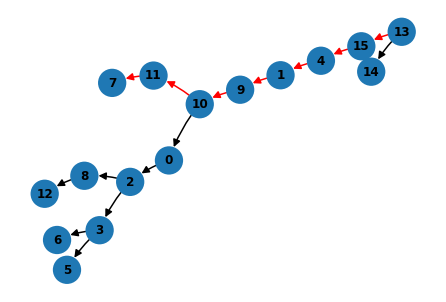

9>10,9>6,0>9,4>0,8>4,13>8,1>13,7>1,11>7,11>5,12>11,2>12,3>2,15>14,15>3|10:15>3>2>12>11>7>1>13>8>4>0>9>10


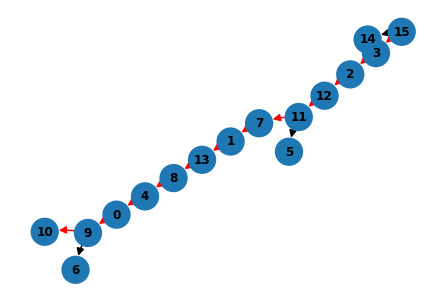

5>10,1>11,13>15,7>9,7>5,0>4,0>1,6>13,6>8,12>7,12>0,3>14,3>6,2>12,2>3|9:2>12>7>9


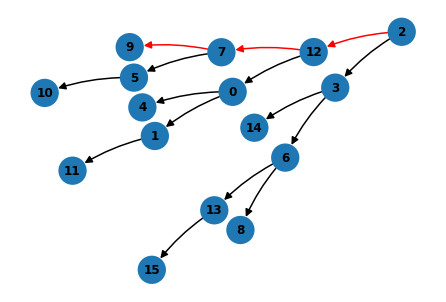

9>6,9>1,7>9,10>11,10>7,2>10,2>8,5>2,3>5,0>3,14>13,14>0,15>14,15>12,4>15|6:4>15>14>0>3>5>2>10>7>9>6


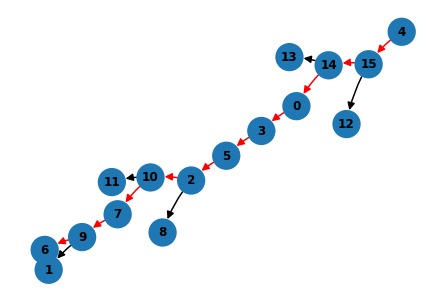

8>4,6>8,7>6,7>5,14>7,9>14,1>9,2>1,3>2,15>3,10>15,0>10,11>0,12>11,13>12|4:13>12>11>0>10>15>3>2>1>9>14>7>6>8>4


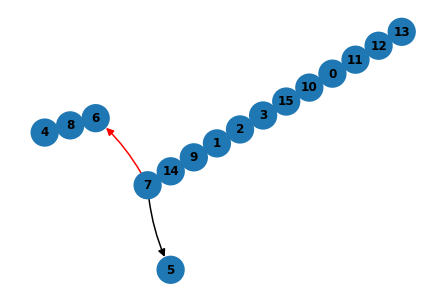

11>15,8>11,4>8,0>7,0>4,3>6,5>1,5>0,2>12,2>3,10>14,9>5,9>2,13>10,13>9|1:13>9>5>1


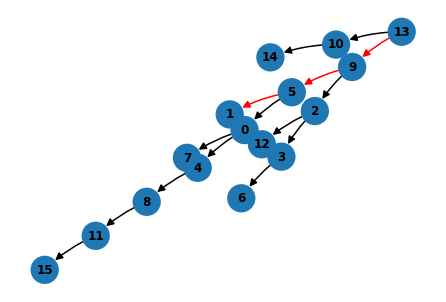

6>4,8>6,14>8,1>14,15>12,15>1,9>15,7>9,0>7,2>0,5>2,3>5,13>3,10>13,11>10|4:11>10>13>3>5>2>0>7>9>15>1>14>8>6>4


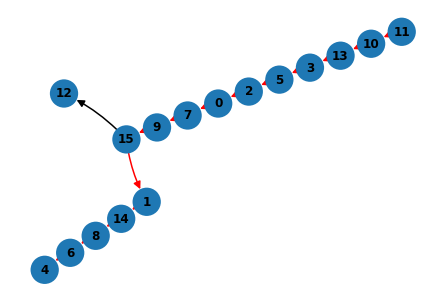

10>8,0>10,4>0,7>4,1>7,11>3,11>1,12>15,6>11,5>14,13>12,13>6,2>5,9>13,9>2|8:9>13>6>11>1>7>4>0>10>8


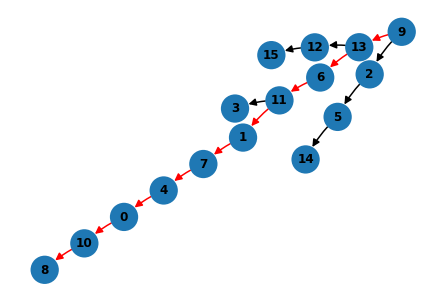

15>6,8>15,10>8,4>11,4>10,0>4,0>2,5>0,12>5,9>12,7>9,3>7,1>14,1>3,13>1|6:13>1>3>7>9>12>5>0>4>10>8>15>6


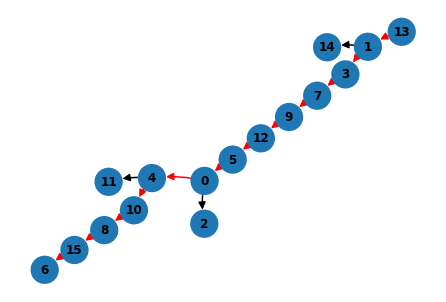

11>2,10>11,5>10,8>5,8>1,9>8,13>9,15>13,0>15,7>0,4>7,14>4,12>14,3>12,6>3|2:6>3>12>14>4>7>0>15>13>9>8>5>10>11>2


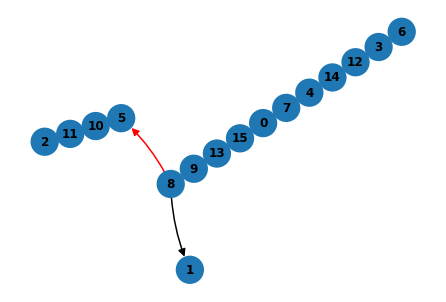

7>10,7>1,8>12,8>7,2>9,0>8,0>2,13>0,11>15,3>13,4>11,4>3,14>4,5>14,6>5|1:6>5>14>4>3>13>0>8>7>1


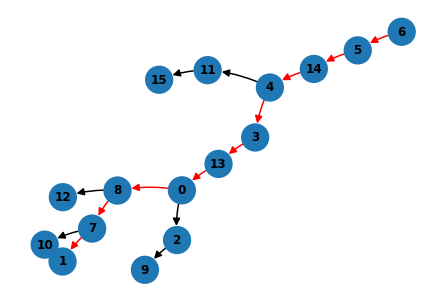

In [107]:
from feature_utils import get_feature_indices, get_feature_datapoints, save_plots_as_images, concat_images_vertically

feature = 244
num_feature_datapoints = 5000
uniform_indices = get_feature_indices(
    feature,
    dictionary_activations,
    k=num_feature_datapoints,
    setting="uniform"
).tolist()

for graph_idx in [x for x in range(1000) if x not in uniform_indices][:20]:
    example_str = generate_example(16, graph_idx, order='backward')
    print(example_str)
    parse_example(example_str)
    plt.show()



In [24]:
def get_diff(clean, corrupted):
    assert clean_codes.keys() == corrupted_codes.keys()
    
    diff = {}
    for key in clean.keys():
        clean_acts = clean[key]
        corrupt_acts = corrupted[key]
        torch.

diff = get_diff(clean_codes, corrupted_codes)